#SQL Querry


WITH HAI_ICD_Patients AS (
    SELECT DISTINCT subject_id, hadm_id
    FROM `physionet-data.mimiciv_hosp.diagnoses_icd`
    WHERE
        icd_code LIKE 'J95851' OR
        icd_code LIKE '99731%' OR
        icd_code LIKE '99931' OR
        icd_code LIKE '99932' OR
        icd_code LIKE '99933' OR
        icd_code LIKE 'T8021%' OR
        icd_code LIKE '99664' OR
        icd_code LIKE 'T8351%'
),

-- Extract demographics and admission details
PatientDetails AS (
    SELECT p.subject_id, p.gender, p.anchor_age AS age,
           a.hadm_id, a.admission_type, a.admission_location, a.admittime, a.dischtime, a.deathtime
    FROM `physionet-data.mimiciv_hosp.patients` p
    JOIN `physionet-data.mimiciv_hosp.admissions` a ON p.subject_id = a.subject_id
    JOIN HAI_ICD_Patients h ON a.subject_id = h.subject_id AND a.hadm_id = h.hadm_id
),

-- Extract clinical notes
RelevantNotes AS (
    SELECT n.subject_id, n.hadm_id, n.charttime, n.text
    FROM `physionet-data.mimiciv_note.discharge` n
    WHERE n.subject_id IN (SELECT subject_id FROM HAI_ICD_Patients)
    UNION ALL
    SELECT r.subject_id, r.hadm_id, r.charttime, r.text
    FROM `physionet-data.mimiciv_note.radiology` r
    WHERE r.subject_id IN (SELECT subject_id FROM HAI_ICD_Patients)
)

-- Combine the information for EDA
SELECT pd.subject_id, pd.gender, pd.age, pd.hadm_id, pd.admission_type,
       pd.admission_location, pd.admittime, pd.dischtime, pd.deathtime,
       rn.charttime, rn.text
FROM PatientDetails pd
LEFT JOIN RelevantNotes rn ON pd.subject_id = rn.subject_id AND pd.hadm_id = rn.hadm_id
ORDER BY pd.subject_id, pd.hadm_id;


In [4]:
# Importing neccassary libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import display, HTML, Image
%matplotlib inline

#plt.style.use('ggplot')
#plt.rcParams.update({'font.size': 20})


In [5]:
df = pd.read_csv('/Users/mohit88/DataspellProjects/pythonProject/venv/dataset/bq-results-20231015-054245-1697348617416.csv')

df.head()

,subject_id,gender,age,hadm_id,admission_type,admission_location,admittime,dischtime,deathtime,charttime,text
0,10004322,M,60,20356134,OBSERVATION ADMIT,EMERGENCY ROOM,2135-02-06 17:52:00,2135-02-12 14:00:00,NaN,2135-02-08 11:53:00,INDICATION: ___ year old man with AMS and abd...
1,10004322,M,60,20356134,OBSERVATION ADMIT,EMERGENCY ROOM,2135-02-06 17:52:00,2135-02-12 14:00:00,NaN,2135-02-06 13:13:00,EXAMINATION: CT C-SPINE W/O CONTRAST\n\nINDIC...
2,10004322,M,60,20356134,OBSERVATION ADMIT,EMERGENCY ROOM,2135-02-06 17:52:00,2135-02-12 14:00:00,NaN,2135-02-06 13:12:00,EXAMINATION: CT HEAD W/O CONTRAST\n\nINDICATI...
3,10004322,M,60,20356134,OBSERVATION ADMIT,EMERGENCY ROOM,2135-02-06 17:52:00,2135-02-12 14:00:00,NaN,2135-02-06 13:43:00,INDICATION: History: ___ with ams*** WARNING ...
4,10004322,M,60,20356134,OBSERVATION ADMIT,EMERGENCY ROOM,2135-02-06 17:52:00,2135-02-12 14:00:00,NaN,2135-02-12 00:00:00,\nName: ___ Unit No: ___\n...


In [8]:
import pandas as pd
import re
import nltk

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    if not isinstance(text, str):
        return ""

    text = text.lower()

    # Remove special characters and numbers using a regex
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and removing stop words
    tokens = text.split()
    tokens = [token for token in tokens if token not in stop_words]

    # Join the tokens back to a string
    return ' '.join(tokens)

# Apply the preprocessing function to the 'text' column
df['cleaned_text'] = df['text'].apply(preprocess_text)

print(df['cleaned_text'])


0        indication year old man ams abdominal pain con...
1        examination ct cspine wo contrast indication r...
2        examination ct head wo contrast indication his...
3        indication history ams warning multiple patien...
4        name unit admission date discharge date date b...
                               ...                        
73368    indication year old man recently placed left s...
73369    examination ct abdomen pelvis contrast indicat...
73370    examination chest fluoro performed without rad...
73371    indication year old man sp lar cb l uretal inj...
73372    name unit admission date discharge date date b...
Name: cleaned_text, Length: 73373, dtype: object


In [9]:
import pandas as pd
import re

# Replace NaNs in the 'cleaned_text' column with an empty string
df['cleaned_text'] = df['cleaned_text'].fillna("")

# Expanded keywords/phrases related to HAI
keywords = [
    r'\binfection\b',  # Using \b ensures we're matching the word "infection" and not substrings like "disinfection"
    r'\bsepsis\b',
    r'\bpneumonia\b',
    r'\bbacteria\b',
    r'\bculture\b',
    r'\bantibiotic\b',
    r'\bmrsa\b',  # Methicillin-resistant Staphylococcus aureus
    r'\bescherichia coli\b',
    r'\bstaphylococcus\b',
    r'\bstreptococcus\b'
]

# Constructing a single regex pattern to match any of the keywords
pattern = '|'.join(keywords)

# Filtering rows using the regex pattern
mask = df['cleaned_text'].str.contains(pattern)
df_hai_relevant = df[mask]


/var/folders/6z/h21x9bt13_zdtt67m39c4_5w0000gn/T/ipykernel_43656/1377793224.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hai_relevant['word_count'] = df_hai_relevant['text'].apply(lambda x: len(str(x).split()))


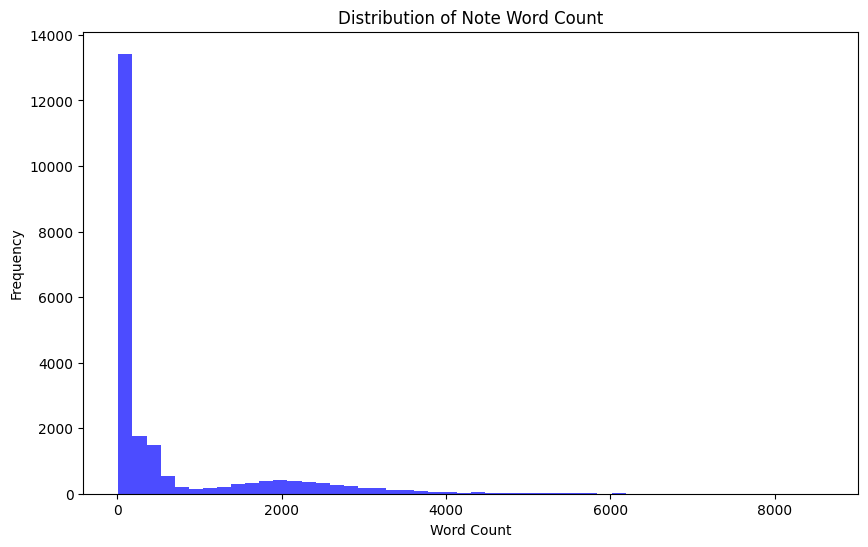

In [10]:
import matplotlib.pyplot as plt

# Calculate the word count for each note
df_hai_relevant['word_count'] = df_hai_relevant['text'].apply(lambda x: len(str(x).split()))

# Plotting the word count
plt.figure(figsize=(10, 6))
plt.hist(df_hai_relevant['word_count'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Note Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


In [15]:
# Create flags for specific HAI terms
keywords_cohort = [
    'hospital-acquired pneumonia', 'hap',
    'ventilator-associated pneumonia', 'vap',
    'healthcare-associated pneumonia',
    'invasive candidiasis', 'invasive aspergillosis',
    'central line-associated bloodstream infection', 'clabsi',
    'catheter-associated urinary tract infection', 'cauti',
    'surgical site infection', 'ssi'
]

# Ensure the dataframe does not give a SettingWithCopyWarning
df_hai_relevant = df_hai_relevant.copy()

for keyword in keywords_cohort:
    df_hai_relevant[keyword] = df_hai_relevant['cleaned_text'].apply(lambda x: 1 if keyword in x else 0)

# Summarize patients based on these flags
patient_cohorts = df_hai_relevant.groupby('subject_id')[keywords_cohort].sum()

# Example: Getting patients who have notes mentioning 'hospital-acquired pneumonia' or 'HAP'
hap_patients = patient_cohorts[(patient_cohorts['hospital-acquired pneumonia'] > 0) | (patient_cohorts['hap'] > 0)]


In [17]:
import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string




In [18]:
# Create the term document matrix
tokenized_text = [text.split() for text in df_hai_relevant['cleaned_text']]
dictionary = corpora.Dictionary(tokenized_text)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in tokenized_text]


In [19]:
# Number of topics you want to extract
num_topics = 5

# Build the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix,
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)


In [20]:
# Print the topics and words associated with them
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)


(0, '0.015*"right" + 0.013*"ct" + 0.012*"normal" + 0.010*"contrast" + 0.010*"left"')
(1, '0.026*"mg" + 0.020*"po" + 0.012*"daily" + 0.010*"blood" + 0.009*"discharge"')
(2, '0.015*"blood" + 0.008*"patient" + 0.008*"mg" + 0.007*"left" + 0.007*"pm"')
(3, '0.016*"left" + 0.015*"right" + 0.010*"head" + 0.009*"ct" + 0.008*"fracture"')
(4, '0.025*"chest" + 0.023*"right" + 0.020*"left" + 0.017*"pneumonia" + 0.015*"pleural"')


In [21]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Note: This might take a while on large datasets
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
vis


/Users/mohit88/opt/anaconda3/envs/newConda/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.255268  0.048593       1        1  41.172788
2      0.161729  0.046559       2        1  25.236482
4     -0.194054  0.146317       3        1  13.933146
0     -0.200593 -0.017181       4        1  11.416052
3     -0.022350 -0.224288       5        1   8.241532, topic_info=            Term           Freq          Total Category  logprob  loglift
7          chest   43789.000000   43789.000000  Default  30.0000  30.0000
410           mg  109722.000000  109722.000000  Default  29.0000  29.0000
33         right   71335.000000   71335.000000  Default  28.0000  28.0000
21          left   67159.000000   67159.000000  Default  27.0000  27.0000
495           po   85214.000000   85214.000000  Default  26.0000  26.0000
...          ...            ...            ...      ...      ...      ...
252         exam    2462.416489   17244.915494   Topic5  -5.6804   0.5496
1399         new    2424.984480   15615.122216   Topic5  -5.6957   0.6336
450        noted    2434.283969   16648.528588   Topic5  -5.6919   0.5733
415         mild    2403.196453   22458.853236   Topic5  -5.7047   0.2611
17    impression    2281.015382   23565.079726   Topic5  -5.7569   0.1608

[406 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
44        1  0.305029      abdomen
44        2  0.100649      abdomen
44        4  0.594297      abdomen
1876      4  0.999867  acquisition
1         1  0.261732        acute
...     ...       ...          ...
694       3  0.694713         year
694       4  0.138255         year
694       5  0.017198         year
2788      5  0.998544          yes
6849      3  0.997533         zone

[806 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 5, 1, 4])

In [25]:
df.head()

,subject_id,gender,age,hadm_id,admission_type,admission_location,admittime,dischtime,deathtime,charttime,text,cleaned_text
0,10004322,M,60,20356134,OBSERVATION ADMIT,EMERGENCY ROOM,2135-02-06 17:52:00,2135-02-12 14:00:00,NaN,2135-02-08 11:53:00,INDICATION: ___ year old man with AMS and abd...,indication year old man ams abdominal pain con...
1,10004322,M,60,20356134,OBSERVATION ADMIT,EMERGENCY ROOM,2135-02-06 17:52:00,2135-02-12 14:00:00,NaN,2135-02-06 13:13:00,EXAMINATION: CT C-SPINE W/O CONTRAST\n\nINDIC...,examination ct cspine wo contrast indication r...
2,10004322,M,60,20356134,OBSERVATION ADMIT,EMERGENCY ROOM,2135-02-06 17:52:00,2135-02-12 14:00:00,NaN,2135-02-06 13:12:00,EXAMINATION: CT HEAD W/O CONTRAST\n\nINDICATI...,examination ct head wo contrast indication his...
3,10004322,M,60,20356134,OBSERVATION ADMIT,EMERGENCY ROOM,2135-02-06 17:52:00,2135-02-12 14:00:00,NaN,2135-02-06 13:43:00,INDICATION: History: ___ with ams*** WARNING ...,indication history ams warning multiple patien...
4,10004322,M,60,20356134,OBSERVATION ADMIT,EMERGENCY ROOM,2135-02-06 17:52:00,2135-02-12 14:00:00,NaN,2135-02-12 00:00:00,\nName: ___ Unit No: ___\n...,name unit admission date discharge date date b...


In [26]:
import pandas as pd

# Assuming your dataframe is called 'df' and the notes column is 'text'
# You may need to adjust column names accordingly

# Define a list of keywords related to HAI
hai_keywords = ["hai", "healthcare acquired infection", "hospital acquired infection",
                "nosocomial infection", "postoperative infection", "sepsis",
                "pneumonia", "bacterial infection"]  # You can add more variants as needed

# Create a mask by checking if any of the keywords is in each note
mask = df['cleaned_text'].str.lower().apply(lambda x: any(keyword in x for keyword in hai_keywords))

# Filter the dataframe
filtered_df = df[mask]

print(filtered_df)


       subject_id gender  age   hadm_id               admission_type  \
3        10004322      M   60  20356134            OBSERVATION ADMIT   
4        10004322      M   60  20356134            OBSERVATION ADMIT   
9        10004733      M   51  27411876                       URGENT   
10       10004733      M   51  27411876                       URGENT   
13       10004733      M   51  27411876                       URGENT   
...           ...    ...  ...       ...                          ...   
73336    19997367      F   63  20617667                       URGENT   
73342    19997367      F   63  20617667                       URGENT   
73352    19997367      F   63  20617667                       URGENT   
73364    19997367      F   63  20617667                       URGENT   
73372    19997538      M   53  22701415  SURGICAL SAME DAY ADMISSION   

           admission_location            admittime            dischtime  \
3              EMERGENCY ROOM  2135-02-06 17:52:00  2135-02-

In [27]:
filtered_df.describe()

,subject_id,age,hadm_id
count,1.788700e+04,17887.000000,1.788700e+04
mean,1.498370e+07,61.244535,2.506791e+07
std,2.872557e+06,16.451900,2.831038e+06
min,1.000432e+07,18.000000,2.000512e+07
25%,1.247454e+07,51.000000,2.271026e+07
50%,1.503178e+07,63.000000,2.507744e+07
75%,1.746355e+07,73.000000,2.748862e+07
max,1.999754e+07,91.000000,2.999962e+07


In [31]:
print(len(df['subject_id'].unique()))

3871


In [32]:
import pandas as pd

# Assuming you've loaded your data into a dataframe named 'filtered_df'
unique_patients_with_hai = filtered_df['subject_id'].nunique()
print(f"Unique patients with HAI mentions: {unique_patients_with_hai}")

admission_counts = filtered_df['hadm_id'].value_counts()
print("\nTop 10 admissions by HAI mentions count:")
print(admission_counts.head(10))


Unique patients with HAI mentions: 3447

Top 10 admissions by HAI mentions count:
27154619    49
29763497    41
29083442    38
28016331    35
26449130    34
28102452    32
27965624    31
24323475    30
22903159    28
25220207    28
Name: hadm_id, dtype: int64


In [33]:
context_window = 10

contexts = []
for index, row in filtered_df.iterrows():
    text = row['text']
    for keyword in hai_keywords:  # assuming hai_keywords is your list of keywords
        if keyword in text:
            words = text.split()
            if keyword in words:
                position = words.index(keyword)
                start = max(0, position - context_window)
                end = min(len(words), position + context_window + 1)
                contexts.append(' '.join(words[start:end]))

print("\nSome Contexts for HAI mentions:")
for context in contexts[:10]:  # Displaying first 10 contexts
    print(context)
    print("----")



Some Contexts for HAI mentions:
retention s/p indwelling foley in ___, admission in ___ for sepsis from pneumonia, presenting with complaints of fever and altered mental
----
4:211 is impossible to characterize. It could be more atelectasis, pneumonia or any mass. Peripheral consolidation in the posterior segment of
----
short term radiographic followup should be performed to exclude developing pneumonia or aspiration. There is no evidence of pneumothorax.
----
short term radiographic followup should be performed to exclude developing pneumonia or aspiration. There is no evidence of pneumothorax. CT CHEST
----
at the left lung base has improved and previously questioned pneumonia has resolved, presumably atelectasis instead. Lung volumes remain extremely low
----
removal with HD. # MSSA pneumonia: Noted to have MSSA pneumonia from sputum culture on ___. He was initially treated with
----
with drop in WBC from 17>13. Never had fever or sepsis syndrome. Second urine culture likely didn'

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.85, max_features=20, stop_words='english')
tfidf = vectorizer.fit_transform(filtered_df['text'])

feature_names = vectorizer.get_feature_names_out()
print("\nTop 20 terms by TF-IDF:")
print(feature_names)



Top 20 terms by TF-IDF:
['10' 'admission' 'blood' 'chest' 'ct' 'daily' 'discharge' 'history'
 'left' 'mg' 'normal' 'pain' 'patient' 'pleural' 'po' 'pulmonary' 'right'
 'seen' 'tablet' 'tube']


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73373 entries, 0 to 73372
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   subject_id          73373 non-null  int64 
 1   gender              73373 non-null  object
 2   age                 73373 non-null  int64 
 3   hadm_id             73373 non-null  int64 
 4   admission_type      73373 non-null  object
 5   admission_location  73373 non-null  object
 6   admittime           73373 non-null  object
 7   dischtime           73373 non-null  object
 8   deathtime           13911 non-null  object
 9   charttime           73368 non-null  object
 10  text                73368 non-null  object
 11  cleaned_text        73373 non-null  object
dtypes: int64(3), object(9)
memory usage: 6.7+ MB


In [37]:
import pandas as pd

# List of HAI related keywords/phrases
keywords_hai = ['hospital-acquired pneumonia', 'infection', 'sepsis', 'bacteria', 'antibiotic', 'fever']

# Create a new column in df to indicate if the patient text contains HAI references
df['has_HAI_ref'] = df['cleaned_text'].apply(lambda x: any(keyword in x for keyword in keywords_hai))

# Filter patients for HAI cohort
hai_cohort = df[df['has_HAI_ref']]

# Summary
print(f"Total number of patients: {len(df['subject_id'].unique())}")
print(f"Number of patients in HAI cohort: {len(hai_cohort['subject_id'].unique())}")


Total number of patients: 3871
Number of patients in HAI cohort: 3817


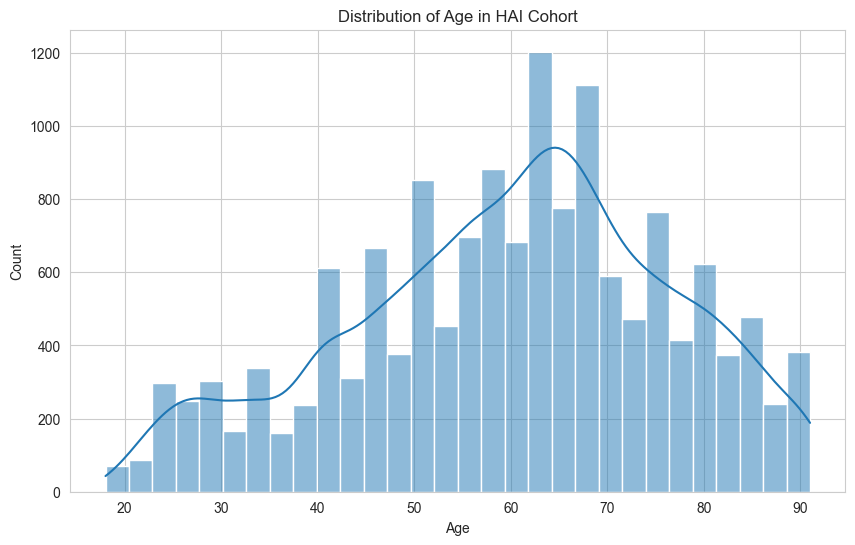

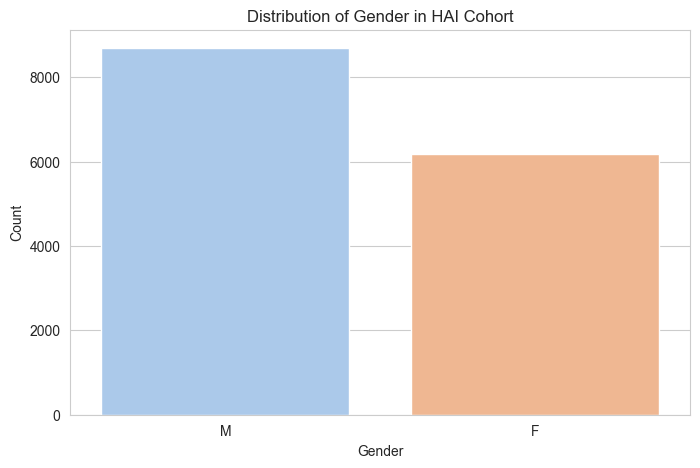

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for seaborn
sns.set_style("whitegrid")

# Distribution of Age
plt.figure(figsize=(10, 6))
sns.histplot(hai_cohort['age'], kde=True, bins=30)
plt.title('Distribution of Age in HAI Cohort')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Distribution of Gender
plt.figure(figsize=(8, 5))
sns.countplot(x='gender', data=hai_cohort, palette="pastel")
plt.title('Distribution of Gender in HAI Cohort')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73373 entries, 0 to 73372
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   subject_id          73373 non-null  int64 
 1   gender              73373 non-null  object
 2   age                 73373 non-null  int64 
 3   hadm_id             73373 non-null  int64 
 4   admission_type      73373 non-null  object
 5   admission_location  73373 non-null  object
 6   admittime           73373 non-null  object
 7   dischtime           73373 non-null  object
 8   deathtime           13911 non-null  object
 9   charttime           73368 non-null  object
 10  text                73368 non-null  object
 11  cleaned_text        73373 non-null  object
 12  has_HAI_ref         73373 non-null  bool  
dtypes: bool(1), int64(3), object(9)
memory usage: 6.8+ MB


In [41]:
# Convert admittime and deathtime to datetime format
hai_cohort['admittime'] = pd.to_datetime(hai_cohort['admittime'])
hai_cohort['deathtime'] = pd.to_datetime(hai_cohort['deathtime'])

# Calculate duration for each patient
hai_cohort['lifespan_after_diagnosis'] = (hai_cohort['deathtime'] - hai_cohort['admittime']).dt.days

# Calculate average duration for patients who died
average_lifespan = hai_cohort.loc[hai_cohort['has_died'] == 1, 'lifespan_after_diagnosis'].mean()
print(f"Average lifespan after HAI diagnosis for patients who died: {average_lifespan:.2f} days")


Average lifespan after HAI diagnosis for patients who died: 33.98 days


/var/folders/6z/h21x9bt13_zdtt67m39c4_5w0000gn/T/ipykernel_43656/1871617461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hai_cohort['admittime'] = pd.to_datetime(hai_cohort['admittime'])
/var/folders/6z/h21x9bt13_zdtt67m39c4_5w0000gn/T/ipykernel_43656/1871617461.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hai_cohort['deathtime'] = pd.to_datetime(hai_cohort['deathtime'])
/var/folders/6z/h21x9bt13_zdtt67m39c4_5w0000gn/T/ipykernel_43656/1871617461.py:6: SettingWithCopyWarning: 
A value is trying

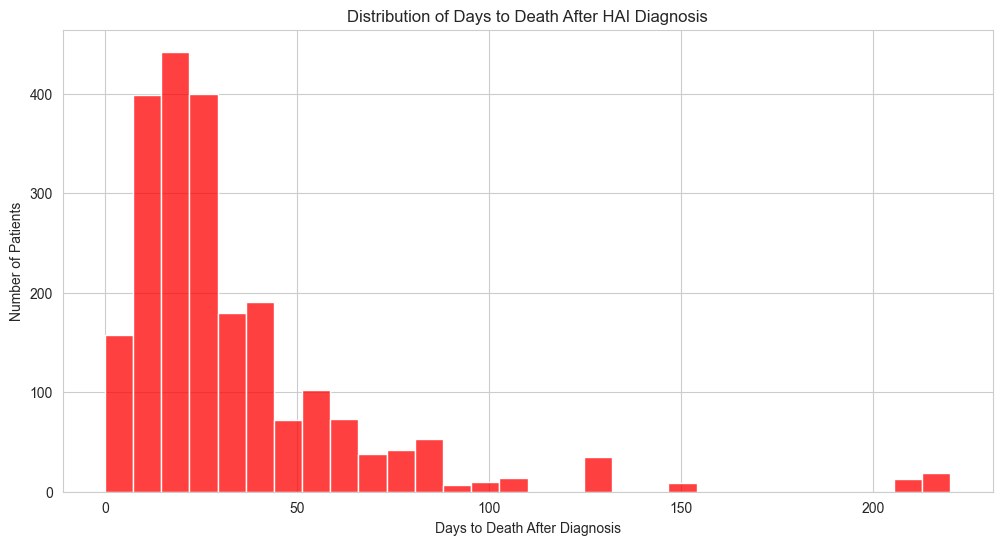

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# Create a histogram for lifespan_after_diagnosis for patients who died
plt.figure(figsize=(12,6))
sns.histplot(hai_cohort[hai_cohort['has_died'] == 1]['lifespan_after_diagnosis'], kde=False, bins=30, color='red')

plt.title('Distribution of Days to Death After HAI Diagnosis')
plt.xlabel('Days to Death After Diagnosis')
plt.ylabel('Number of Patients')
plt.show()
